# **Question 4.** Heat transfer process

<font size=5>
Consider a heat transfer process that follows the following equation:

\begin{equation}
\frac{\partial S (x,y,t)}{\partial t}
=
\alpha (\frac{\partial^2 S}{\partial x^2} + \frac{\partial^2 S}{\partial y^2} )
\end{equation}
 
where $0 \leq x, y \leq 0.05$ represents the location of each pixel, $\alpha$ is the thermal diffusivity coefficient, and t is the time frame. The initial boundary conditions are set such that $S |_{t=1} = 0$ and $S |_{x=0} = S|_{x=0.05} = S|_{y=0} = S|_{y=0.05}=1$. At each time , the image is recorded at locations $x = \frac{j}{n+1}, y=\frac{k}{n+1}, j,k=1, ... , n$, resulting in an n x n matrix. Here we set n=21 and t=1, ... , 10, which leads to 10 images of size 21 x 21, that can be represented as a 21x21x10 tensor.



The thermal diffusivity coefficient depends on the material being heated. In the dataset heatT.mat, we have tensor 1, tensor 2 and tensor 3 corresponding to a heat transfer process in material 1, material 2 and material 3, respectively. 
</font>

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
import tensorly as tl
from tensorly import unfold
from tensorly.tenalg import inner
from tensorly.decomposition import parafac
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
import re
import cv2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### **Part 1.** Try different ranks for CP decomposition and use AIC to choose the optimal one.

In [2]:
#load data from .mat file
data = loadmat('heatT.mat')

In [3]:
#extract data from nested arrays from loading of the .mat file
T1 = data['T1'][0][0][0]
T2 = data['T2'][0][0][0]
T3 = data['T3'][0][0][0]

print('T1 shape', T1.shape, '\nT2 shape', T2.shape, '\nT3 shape', T3.shape)

T1 shape (21, 21, 10) 
T2 shape (21, 21, 10) 
T3 shape (21, 21, 10)


In [4]:
#function to help view the data
def multi_plot(T, title):
    plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    
    for i in range(1, T.shape[2]+1):
        plt.subplot(2,5,i)
        plt.imshow(T[:,:,i-1])
        
    plt.suptitle(title)
        
    plt.show()

### Visualize each component of the Tensors

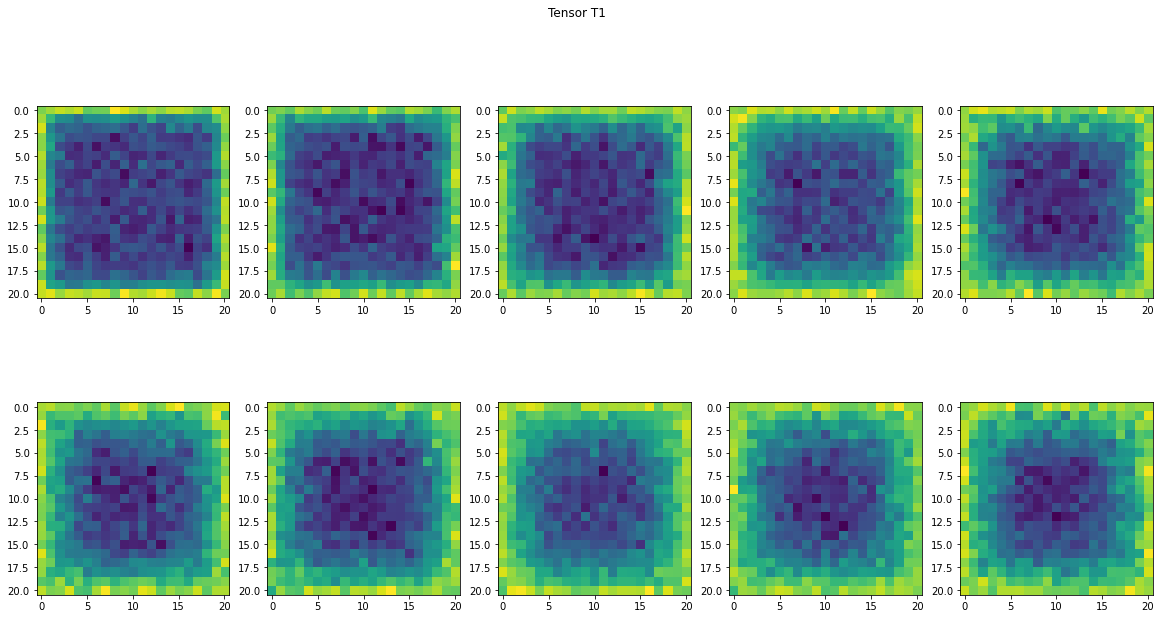

In [5]:
multi_plot(T1, 'Tensor T1')

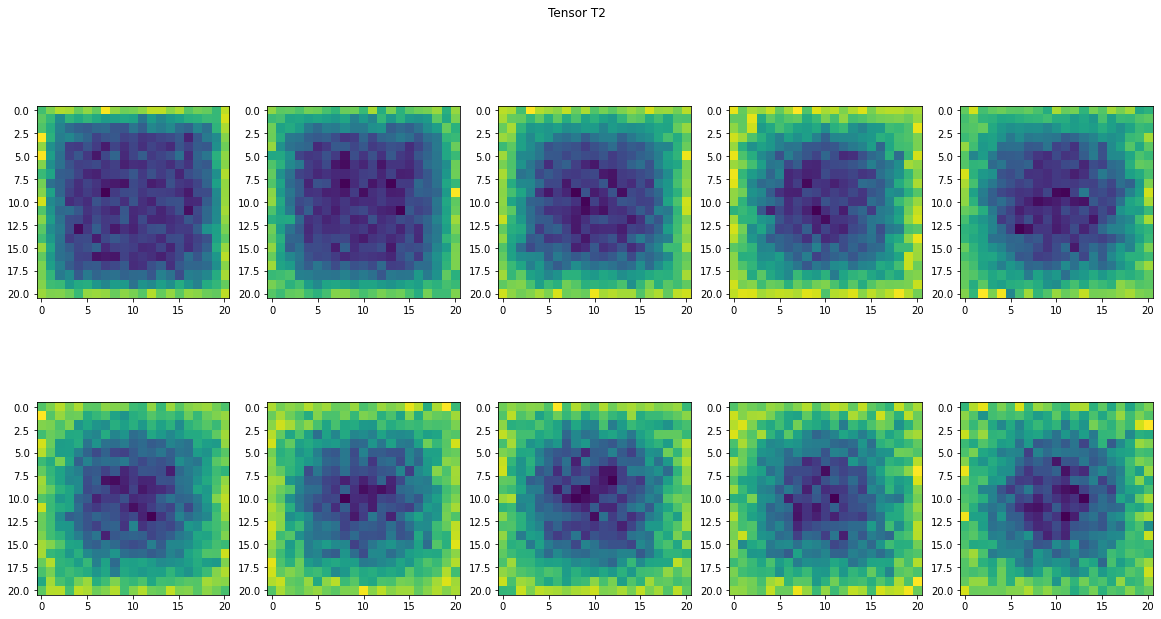

In [6]:
multi_plot(T2, 'Tensor T2')

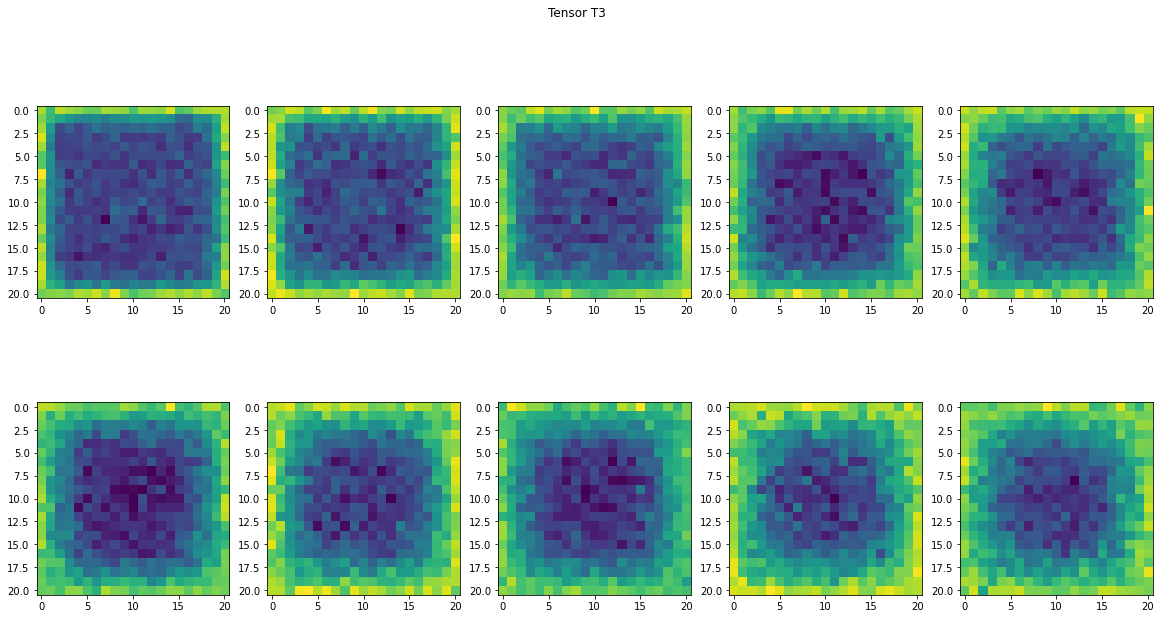

In [7]:
multi_plot(T3, 'Tensor T3')

In [8]:
#convert numpy array to tensorly tensors
T1 = tl.tensor(T1, dtype=tl.float32)
T2 = tl.tensor(T2, dtype=tl.float32)
T3 = tl.tensor(T3, dtype=tl.float32)

In [9]:
#function to calculate all AICs for each tensor
def find_lowest(t1, t2, t3):
    #initialize lists to store errors for each rank of decomposition
    t1_aic = []
    t2_aic = []
    t3_aic = []
    
    #try out up to 20 different ranks
    for r in range(1,21):
        #weights, and factors from each decomp on each tensor
        w1, f1 = parafac(t1, r, normalize_factors=True)
        w2, f2 = parafac(t2, r, normalize_factors=True)
        w3, f3 = parafac(t3, r, normalize_factors=True)
        
        #reconstruct from factors
        x1 = tl.kruskal_to_tensor((w1,f1))
        x2 = tl.kruskal_to_tensor((w2,f2))
        x3 = tl.kruskal_to_tensor((w3,f3))
        
        #calculate error in reconstruction
        err1 = err(t1, x1)
        err2 = err(t2, x2)
        err3 = err(t3, x3)
              
        #calculate AIC using rank as the penalization term instead of number of parameters as suggested by prof on Piazza
        t1_aic.append(AIC(err1, r))
        t2_aic.append(AIC(err2, r))
        t3_aic.append(AIC(err3, r))
    
    #return the 3 arrays each containing 20 different AIC values
    return t1_aic, t2_aic, t3_aic

In [10]:
def err(orig, calc):
    diff = orig - calc
    err = (diff**2).sum()
    return err

In [11]:
def AIC(err, r):
    return 2*err + (2*r)

In [12]:
#get AIC values
a1,a2,a3=find_lowest(T1,T2,T3)

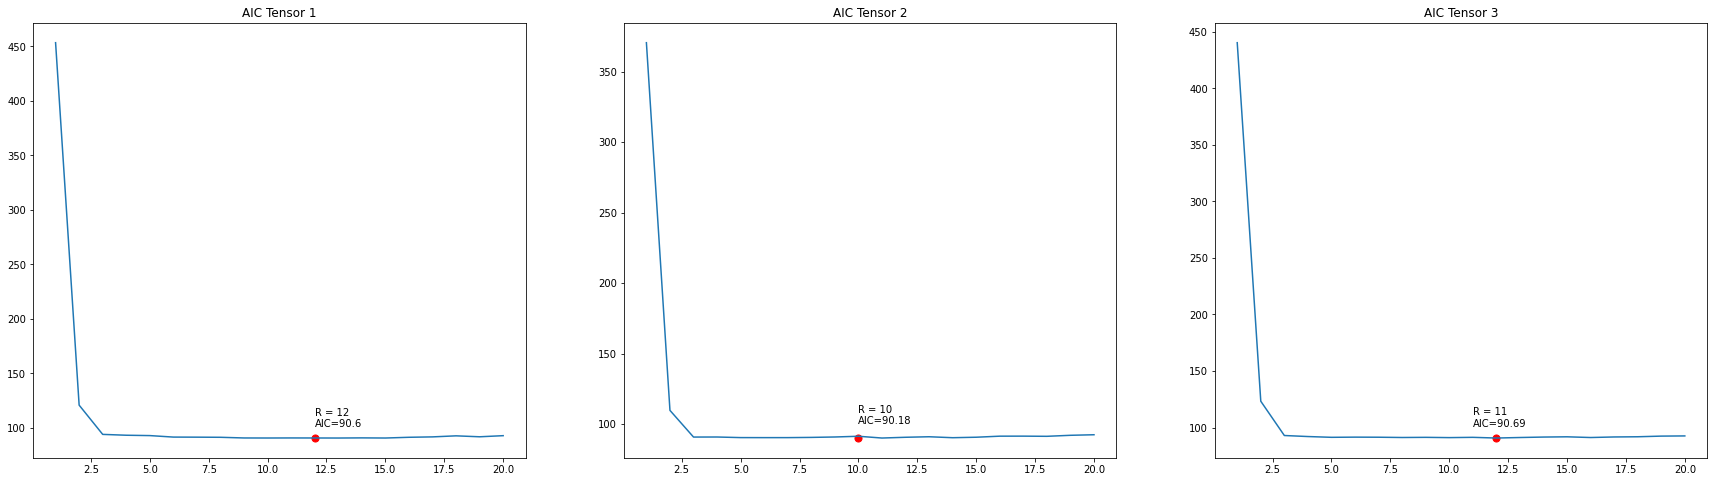

In [13]:
plt.subplots(nrows=1, ncols=3, figsize=(30,8))
plt.subplot(131)
plt.plot(range(1,len(a1)+1),a1)
plt.scatter(np.argmin(a1), min(a1), color='r', s=50)
plt.text(np.argmin(a1), min(a1)+10, 'R = {}\nAIC={}'.format(np.argmin(a1), round(min(a1),2)))
plt.title('AIC Tensor 1')

plt.subplot(132)
plt.plot(range(1,len(a2)+1),a2)
plt.scatter(np.argmin(a2), min(a2), color='r', s=50)
plt.text(np.argmin(a2), min(a2)+10, 'R = {}\nAIC={}'.format(np.argmin(a2), round(min(a2),2)))
plt.title('AIC Tensor 2')

plt.subplot(133)
plt.plot(range(1,len(a3)+1),a3)
plt.scatter(np.argmin(a1), min(a3), color='r', s=50)
plt.text(np.argmin(a3), min(a3)+10, 'R = {}\nAIC={}'.format(np.argmin(a3), round(min(a3),2)))
plt.title('AIC Tensor 3')
plt.show()

### **Part 2.** Use CP decomposition to decouple temporal and spatial patterns of the three materials in heat transfer processes. Plot the first 4 spatial and temporal patterns of tensor 1.

In [14]:
#use the optimal rank from Part 1
r1 = np.argmin(a1)
r2 = np.argmin(a2)
r3 = np.argmin(a3)

In [15]:
#use CP decomp using optimal ranks
w1, f1 = parafac(T1, r1, normalize_factors=True)
w2, f2 = parafac(T2, r2, normalize_factors=True)
w3, f3 = parafac(T3, r3, normalize_factors=True)

In [16]:
#weights and factor columns are not sorted in descending order - sort them in descending order
sorted_lambdas_and_indices = sorted(list(zip(range(len(w1)), w1)), key=lambda x: x[1], reverse=True)
sorted_idxs = [x[0] for x in sorted_lambdas_and_indices]
sorted_lambdas = [x[1] for x in sorted_lambdas_and_indices]
sorted_lambdas_and_indices

[(0, 40.57829),
 (10, 9.616071),
 (1, 7.672068),
 (2, 3.868541),
 (11, 3.7067842),
 (7, 2.519711),
 (3, 1.8275048),
 (4, 1.452806),
 (8, 1.4356604),
 (5, 1.4246788),
 (9, 1.4000778),
 (6, 1.0527846)]

In [17]:
#sort factor columns based of of weight orders
factor1 = f1[0][:,sorted_idxs]
factor2 = f1[1][:,sorted_idxs]
factor3 = f1[2][:,sorted_idxs]

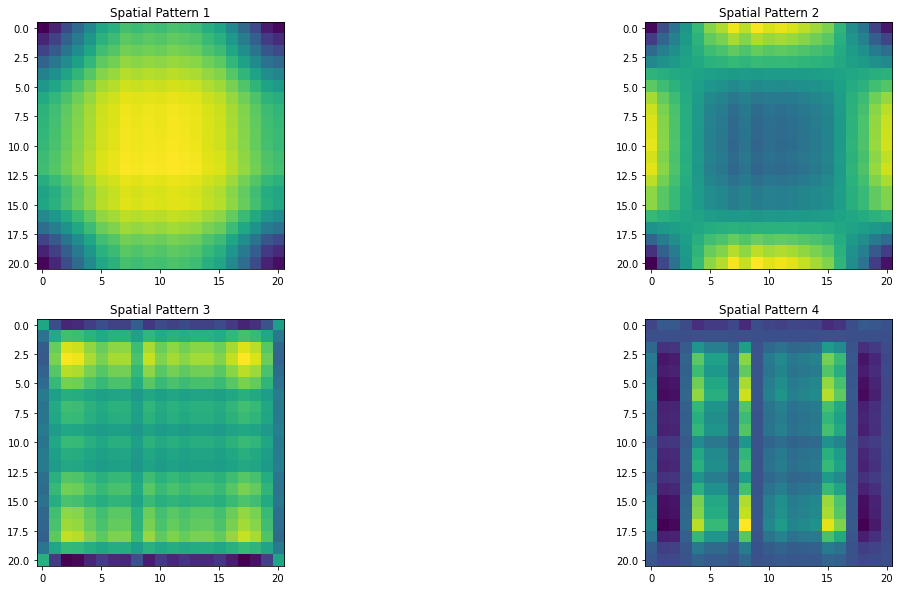

In [18]:
plt.subplots(nrows=2, ncols=2, figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow((np.kron(factor1[:,i] , factor2[:,i]) * sorted_lambdas[i]).reshape((21,21)))
    plt.title('Spatial Pattern {}'.format(i+1))
    
plt.show()

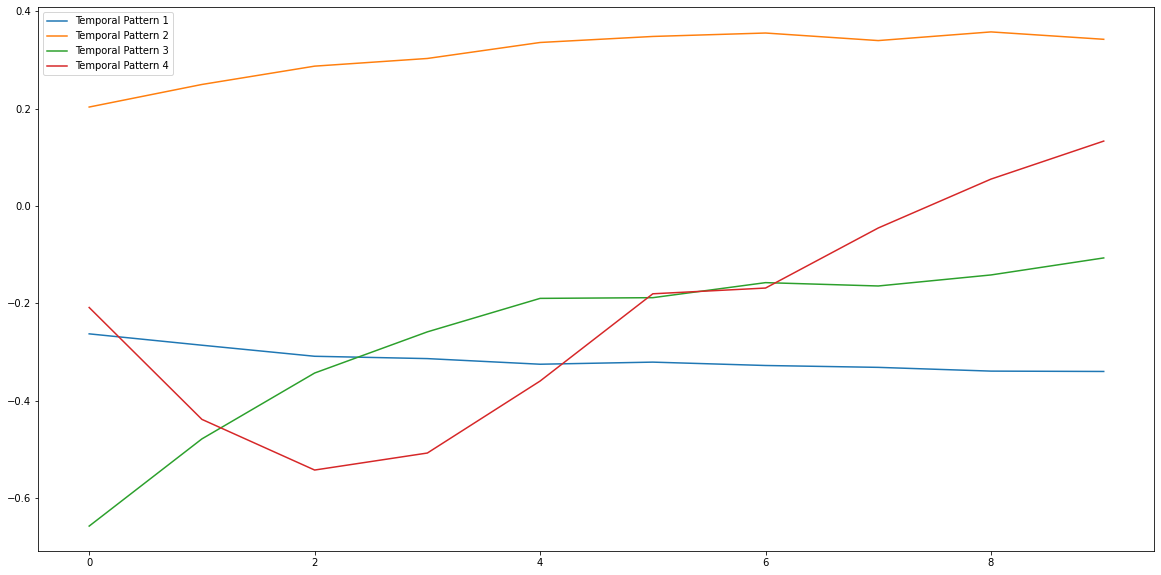

In [19]:
plt.figure(figsize=(20,10))
for i in range(4):
    plt.plot(factor3[:,i], label='Temporal Pattern {}'.format(i+1))

plt.legend()
plt.show()